In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.losses import BinaryCrossentropy, binary_crossentropy
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Input, RepeatVector, Reshape, concatenate, UpSampling2D, Permute, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os

In [2]:
!pip install googledrivedownloader segmentation-models
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1KVfrTao_0XzUWLI4-JgGZJOLE0ddjwto', dest_path='./data/file.zip', unzip=True)

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 1.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Unzipping...Done.
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
lst   = os.listdir('/kaggle/working/data/images/')
mask = []
img = []
for filename in lst:
    if filename.endswith('.jpg'):
        img.append('/kaggle/working/data/images/' + filename)
    if filename.endswith('.png'):
        mask.append('/kaggle/working/data/images/' + filename)

img.sort()
mask.sort()
#df = pd.DataFrame({'Filepath_Image':img, 'Filepath_Mask':mask, 'Class':'0'})

In [4]:
n = 1500
x = np.zeros((n, 256, 256, 3), dtype=np.float16)
y = np.zeros((n, 256, 256, 3), dtype=np.float16)

for i in tqdm(range(n)):
    imx = cv2.imread(img[i])
    imx = cv2.cvtColor(imx, cv2.COLOR_BGR2RGB)
    imx = cv2.resize(imx, (256, 256))
    imx = imx / 255.0
    x[i,:,:, :] = imx
    
for i in tqdm(range(n)):
    msk = cv2.imread(mask[i], 0)
    msk = cv2.resize(msk, (256, 256))
    y[i,:,:,0] = (msk == 1) * 1.0
    y[i,:,:,1] = (msk == 2) * 1.0
    y[i,:,:,2] = (msk == 3) * 1.0
    
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [5]:
model = sm.Unet('resnet34', input_shape=(256, 256, 3), encoder_weights=None, classes=3, activation='softmax')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.001, min_lr = 1e-8)

In [6]:
history = model.fit(x_train, y_train, epochs = 40, batch_size = 16, validation_data = (x_val, y_val), callbacks=[ModelCheckpoint('modelx.model', monitor = 'metric')])

Epoch 1/40
75/75 [==============================] - 40s 529ms/step - loss: 1.0701 - iou_score: 0.3792 - val_loss: 3.4654 - val_iou_score: 0.3037
Epoch 2/40
75/75 [==============================] - 37s 500ms/step - loss: 0.9204 - iou_score: 0.4622 - val_loss: 1.5306 - val_iou_score: 0.4079
Epoch 3/40
75/75 [==============================] - 39s 515ms/step - loss: 0.8395 - iou_score: 0.5071 - val_loss: 1.3697 - val_iou_score: 0.4846
Epoch 4/40
75/75 [==============================] - 39s 517ms/step - loss: 0.7788 - iou_score: 0.5407 - val_loss: 1.0627 - val_iou_score: 0.5340
Epoch 5/40
75/75 [==============================] - 38s 510ms/step - loss: 0.7372 - iou_score: 0.5636 - val_loss: 1.8885 - val_iou_score: 0.4309
Epoch 6/40
75/75 [==============================] - 39s 522ms/step - loss: 0.7129 - iou_score: 0.5778 - val_loss: 1.0718 - val_iou_score: 0.4999
Epoch 7/40
75/75 [==============================] - 39s 517ms/step - loss: 0.6703 - iou_score: 0.6016 - val_loss: 0.7659 - val_iou

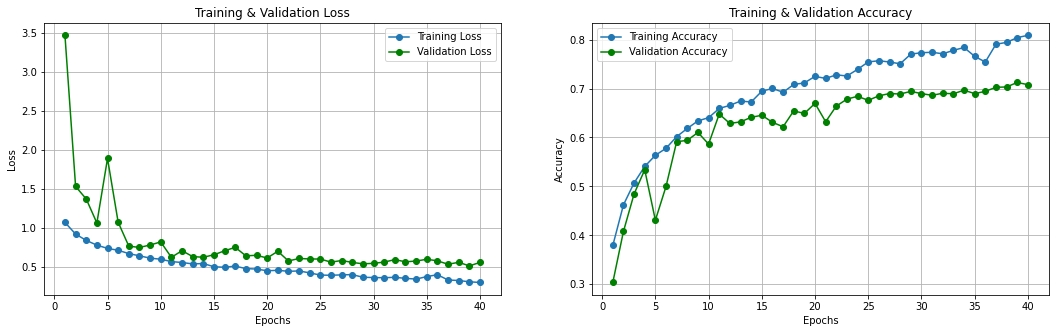

In [7]:
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['iou_score'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['iou_score']
val_acc_vals = history.history['val_iou_score']

ax[1].plot(epochs, acc_vals, marker='o', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [8]:
to_predict = np.asarray(x[:100], dtype=np.float32)
out = model.predict(to_predict)
original_mask = np.asarray(y[:100], dtype=np.float32)

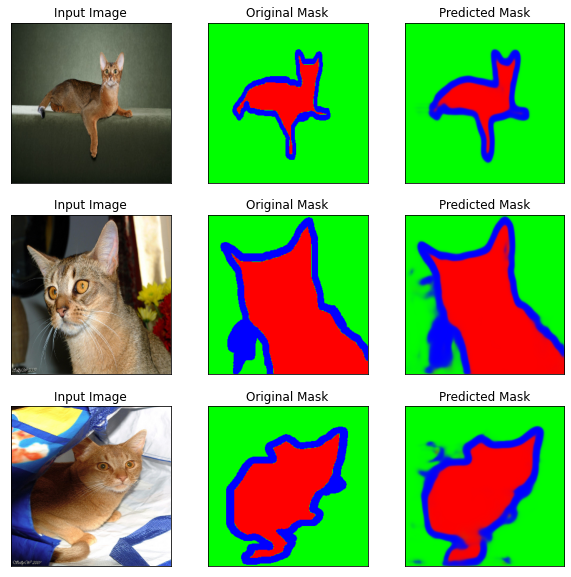

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

ax[0, 0].imshow(to_predict[0])
ax[0, 0].set_title('Input Image')
ax[0, 0].set_xticks([]), ax[0, 0].set_yticks([])
ax[0, 1].imshow(original_mask[0])
ax[0, 1].set_title('Original Mask')
ax[0, 1].set_xticks([]), ax[0, 1].set_yticks([])
ax[0, 2].imshow(out[0])
ax[0, 2].set_title('Predicted Mask')
ax[0, 2].set_xticks([]), ax[0, 2].set_yticks([])

ax[1, 0].imshow(to_predict[10])
ax[1, 0].set_title('Input Image')
ax[1, 0].set_xticks([]), ax[1, 0].set_yticks([])
ax[1, 1].imshow(original_mask[10])
ax[1, 1].set_title('Original Mask')
ax[1, 1].set_xticks([]), ax[1, 1].set_yticks([])
ax[1, 2].imshow(out[10])
ax[1, 2].set_title('Predicted Mask')
ax[1, 2].set_xticks([]), ax[1, 2].set_yticks([])

ax[2, 0].imshow(to_predict[2])
ax[2, 0].set_title('Input Image')
ax[2, 0].set_xticks([]), ax[2, 0].set_yticks([])
ax[2, 1].imshow(original_mask[2])
ax[2, 1].set_title('Original Mask')
ax[2, 1].set_xticks([]), ax[2, 1].set_yticks([])
ax[2, 2].imshow(out[2])
ax[2, 2].set_title('Predicted Mask')
ax[2, 2].set_xticks([]), ax[2, 2].set_yticks([])
plt.show()